In [54]:
import torch
from torch.optim.sgd import SGD
import kornia
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from guided_filter_pytorch.guided_filter import GuidedFilter2d

def tensor_to_numpy(tensor, normalize=False):
    out_np: np.ndarray = kornia.utils.tensor_to_image(tensor.to(device='cpu')).clip(0.0, 1.0)
    if normalize:
        min_val = np.min(out_np)
        max_val = np.max(out_np)
        if min_val == max_val:
            return out_np
        # Normalize the image to range [0, 1]
        out_np = (out_np - min_val) / (max_val - min_val)
    return out_np

def save_tensor_image(tensor, path, normalize=False):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    array = tensor_to_numpy(tensor, normalize)
    image = Image.fromarray(np.uint8(array * 255))
    image.save(path)

def imshow(input: torch.Tensor, normalize=False):
    # out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out = tensor_to_numpy(input, normalize)
    plt.imshow(out, cmap='gray')
    plt.axis("off")
    plt.show()

def image_refine(ref, edit, loss_fn, iteration, weight=1.0, v=False, v_iter=10, v_dir='experiments/temp'):
    edit_copy = edit.clone()
    edit_copy.requires_grad = True
    os.makedirs(os.path.join(v_dir, 'image'), exist_ok=True)
    os.makedirs(os.path.join(v_dir, 'grad'), exist_ok=True)

    for i in range(iteration):
        edit_copy.requires_grad = True
        optimizer = SGD(params=[edit_copy], lr=1e-1)
        optimizer.zero_grad()
        loss = weight * loss_fn(ref, edit_copy)
        loss.backward()
        optimizer.step()
        grad = edit_copy.grad
        edit_copy = torch.clamp(edit_copy.detach(), 0.0, 1.0)

        if v and i % v_iter == 0:
            print(f'{i} iter loss : {loss}')
            out_image_path = os.path.join(v_dir, 'image', f'{i}.png')
            out_grad_path = os.path.join(v_dir, 'grad', f'{i}.png')

            save_tensor_image(edit_copy, out_image_path)
            save_tensor_image(grad, out_grad_path, True)
    
    return edit_copy

In [55]:
def guided_MSE(ref, edit):
    GF = GuidedFilter2d(5, 1e-4, True)
    guided = GF(ref, edit)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(ref, guided)
    return loss

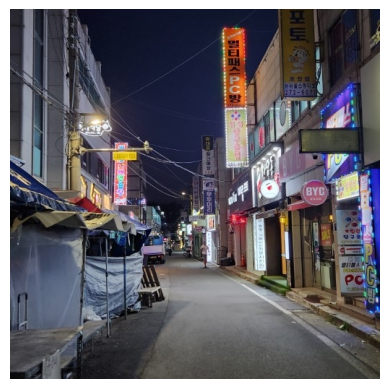

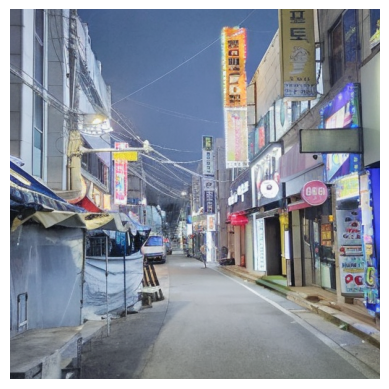

In [56]:
ref_tensor = kornia.io.load_image("images/a photo of street at night.jpg", kornia.io.ImageLoadType.RGB32, device='cuda')[None, ...]  # BxCxHxW
imshow(ref_tensor)
edit_tensor = kornia.io.load_image("images/a photo of street at day_self1.0.png", kornia.io.ImageLoadType.RGB32, device='cuda')[None, ...]  # BxCxHxW
imshow(edit_tensor)

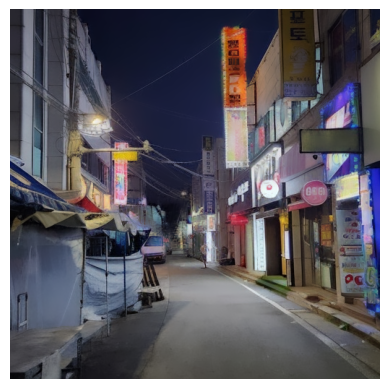

In [57]:
GF = GuidedFilter2d(5, 1e-4, True)
edit_filterd = GF(ref_tensor, edit_tensor)
imshow(edit_filterd)

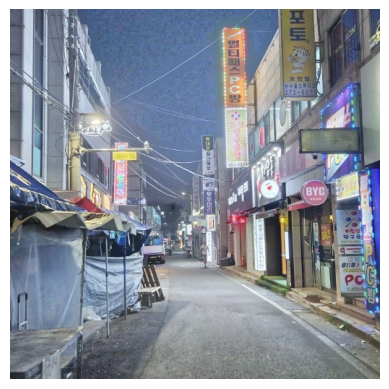

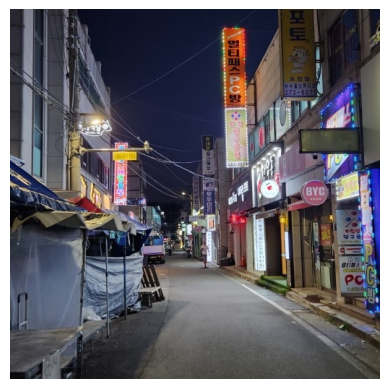

In [58]:
edit_refine = image_refine(ref_tensor, edit_tensor, guided_MSE, 10000, 10000, False)
edit_refine_filtered = GF(ref_tensor, edit_refine)
imshow(edit_refine)
imshow(edit_refine_filtered)
save_tensor_image(edit_refine, f'experiments/20240620_Guided/day_refine.png')
save_tensor_image(edit_refine_filtered, f'experiments/20240620_Guided/day_refine_filtered.png')